In [2]:
# imports

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import tensorly as tl
from tensorly import check_random_state
from tensorly.cp_tensor import CPTensor
from ncistd import (
    SparseCP,    
    visualize_3d_tensor, 
    plot_factors_heatmap, 
    simulated_sparse_tensor, 
    pairs_precision_recall
)
import tlviz
from tlviz.factor_tools import factor_match_score, cosine_similarity
from tlviz.model_evaluation import relative_sse

from sklearn.model_selection import ParameterGrid

# seed & random state
seed = 9481
rns = check_random_state(seed)


In [3]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [4]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

div_hexes = ['#7222D3', neutral_color, '#FF780A']
div_cmap = get_continuous_cmap(div_hexes)


# Simulated Data

In [5]:
# generate simulated data

true_rank = 8
true_shape = [50, 20, 30]
true_densities = [.4, .8, .6]
# true_densities = [.2, .2, .2]

# re-seed simulated data until all factor matrices are full rank
full_rank = False
while not full_rank:
    # generate simulated tensor
    sim_tensor = simulated_sparse_tensor(
        shape=true_shape,                
        rank=true_rank,                         
        densities=true_densities, 
        factor_dist_list=[scipy.stats.uniform(loc=-1, scale=2), 
                         scipy.stats.uniform(), 
                         scipy.stats.uniform()], 
        random_state=rns
    )
    # check that all factors are full rank
    full_rank = np.all([np.linalg.matrix_rank(factor) == true_rank for factor in sim_tensor.factors])

# Ensure that factor matrices are full rank
for factor in sim_tensor.factors:
    print(np.linalg.matrix_rank(factor))
    

8
8
8


In [6]:
# visualize simulated tensor data

# fig = visualize_3d_tensor(sim_tensor.to_tensor(), 
#                           shell=False, 
#                           midpoint=0, 
# #                           range_color=[-1, 1]
#                          )
# fig.write_image('../figures/simulated_tensor.png', scale=3)
# fig.show()


In [7]:
# # TODO: build function to plot individual factors. This works for now

# i = 9
# f_1 = [np.array([f[:, i]]).T for f in sim_tensor.factors]
# c_1 = CPTensor((np.array([sim_tensor.weights[i]]), f_1))

# fig = visualize_3d_tensor(c_1.to_tensor(), 
#                           shell=False, 
#                           midpoint=0, 
# #                           range_color=[-1, 1]
#                          )
# fig.write_image('../figures/simulated_factor_{}.png'.format(i), scale=3)
# fig.show()


# Figure 1a

Reconstruction error as a function of rank


In [8]:
# Decomposition with range of components and l1 coefficient manually tuned 

# model parameters
replicates = ['A', 'B', 'C']
noise_level = 1.0
model_params = {
    'rank': [int(i) for i in np.linspace(1, 12, 12)], 
    'lambdas': [[i, 0.0, 0.0] for i in [0.0, 0.1, 5.0]], 
    'nonneg_modes': [[1, 2]],
    'tol': [1e-6], 
    'n_iter_max': [1000], 
    'n_initializations': [5]
}
param_grid = list(ParameterGrid(model_params))

# make noisy simulated tensors
tensors = {}
for rep in replicates:
    tensors[rep] = sim_tensor.to_tensor(noise_level=noise_level, sparse_noise=True, random_state=rns)

results = []
# iterate through decompositions
for i, params in enumerate(param_grid):
    print('Decomposition {} of {}: {}'.format(i, len(param_grid), params))
    # fit model to each replicate
    cps = {}
    for rep in replicates:
        cps[rep] = SparseCP(**params, random_state=rns).fit_transform(tensors[rep], threads=1, verbose=0)
    # calculate cross-validated and ground truth error
    for modeled_rep in replicates:
        for comparison_rep in replicates:
            # calculate cross-validated SSE
            if modeled_rep != comparison_rep:
                sse = relative_sse(cps[modeled_rep], tensors[comparison_rep])
                comparison = 'cross-validation'
            # calculate ground truth comparison SSE
            elif modeled_rep == comparison_rep:
                sse = relative_sse(cps[modeled_rep], sim_tensor.to_tensor())
                comparison = 'ground truth'
            # append results
            results.append({
                'modeled_replicate': modeled_rep, 
                'comparison_replicate': comparison_rep, 
                'comparison': comparison, 
                'rank': params['rank'], 
                'lambda': params['lambdas'][0], 
                'SSE': sse
            })
                

rank_df = pd.DataFrame(results)
rank_df


Decomposition 0 of 36: {'lambdas': [0.0, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 1, 'tol': 1e-06}
Decomposition 1 of 36: {'lambdas': [0.0, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 2, 'tol': 1e-06}
Decomposition 2 of 36: {'lambdas': [0.0, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 3, 'tol': 1e-06}
Decomposition 3 of 36: {'lambdas': [0.0, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 4, 'tol': 1e-06}
Decomposition 4 of 36: {'lambdas': [0.0, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 5, 'tol': 1e-06}
Decomposition 5 of 36: {'lambdas': [0.0, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 6, 'tol': 1e-06}
Decomposition 6 of 36: {'lambdas': [0.0, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 7,

,modeled_replicate,comparison_replicate,comparison,rank,lambda,SSE
0,A,A,ground truth,1,0.0,0.972480
1,A,B,cross-validation,1,0.0,0.986283
2,A,C,cross-validation,1,0.0,0.986405
3,B,A,cross-validation,1,0.0,0.986200
4,B,B,ground truth,1,0.0,0.972515
...,...,...,...,...,...,...
319,B,B,ground truth,12,5.0,0.399559
320,B,C,cross-validation,12,5.0,0.700880
321,C,A,cross-validation,12,5.0,0.707528
322,C,B,cross-validation,12,5.0,0.708540


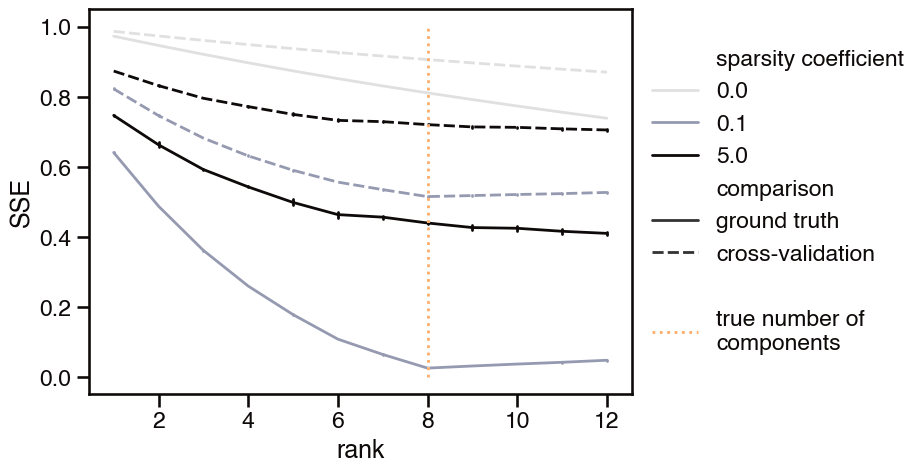

In [9]:
# plot SSE vs. rank by λ

rank_df['sparsity coefficient'] = ['{}'.format(l) for l in rank_df['lambda']]

fig, axis = plt.subplots(figsize=(7, 5))
fig = sns.lineplot(
    x='rank', 
    y='SSE', 
    hue='sparsity coefficient', 
    palette=sns.color_palette([grays[i] for i in [6, 3, 0]]), 
    style='comparison', 
    errorbar='se', 
    err_style='bars',
    data=rank_df, 
    ax=axis
)
plt.vlines(x=8, ymin=0, ymax=1, colors='white', linestyles='dotted', label=' ')    # hack for blank space in legend
plt.vlines(x=8, ymin=0, ymax=1, colors=accent_colors[1], linestyles='dotted', label='true number of\ncomponents')
plt.legend(loc='center left', bbox_to_anchor=[1, 0.5]);


# Figure 1b

Reconstruction error and fms as a function of lambda

In [10]:
# Decomposition with range of components and l1 coefficient manually tuned 

# model parameters
replicates = ['A', 'B', 'C']
noise_level = 1.
model_params = {
    'rank': [8],
    'lambdas': [[i, 0.0, 0.0] for i in np.logspace(-3, 2, num=20)], 
    'nonneg_modes': [[1, 2]],
    'tol': [1e-6], 
    'n_iter_max': [1000], 
    'n_initializations': [5]
}
param_grid = list(ParameterGrid(model_params))

# make noisy simulated tensors
tensors = {}
for rep in replicates:
    tensors[rep] = sim_tensor.to_tensor(noise_level=noise_level, sparse_noise=True, random_state=rns)

results = []
# iterate through decompositions
for i, params in enumerate(param_grid):
    print('Decomposition {} of {}: {}'.format(i, len(param_grid), params))
    # fit model to each replicate
    cps = {}
    for rep in replicates:
        cps[rep] = SparseCP(**params, random_state=rns).fit_transform(tensors[rep], threads=1, verbose=0)
    # calculate cross-validated and ground truth error
    for modeled_rep in replicates:
        for comparison_rep in replicates:
            # calculate ground truth comparison metrics
            if modeled_rep == comparison_rep:
                comparison = 'ground truth'
                sse = relative_sse(cps[modeled_rep], sim_tensor.to_tensor())
                fms = factor_match_score(sim_tensor, cps[modeled_rep], consider_weights=False)
                clusters_true = sim_tensor.get_clusters(0, boolean=True)
                clusters_fit = cps[modeled_rep].get_clusters(0, boolean=True)
                precision, recall = pairs_precision_recall(clusters_true, clusters_fit)
                prerec = (precision + recall) / 2
            # calculate cross-validated metrics FMS & SSE
            elif modeled_rep < comparison_rep:
                comparison = 'cross-validation'
                fms = factor_match_score(cps[comparison_rep], cps[modeled_rep], consider_weights=False)
                sse = relative_sse(cps[modeled_rep], tensors[comparison_rep])
                precision = recall = prerec = np.nan
            # calculate only cross-validated SSE
            elif modeled_rep > comparison_rep:
                comparison = 'cross-validation'
                sse = relative_sse(cps[modeled_rep], tensors[comparison_rep])
                fms = precision = recall = prerec = np.nan
            # append results
            results.append({
                'modeled_replicate': modeled_rep, 
                'comparison_replicate': modeled_rep, 
                'comparison': comparison,
                'rank': params['rank'], 
                'lambda': params['lambdas'][0], 
                'SSE': sse, 
                'FMS': fms, 
                'precision': precision,
                'recall': recall, 
                'precision-recall': prerec
            })
            
lambda_df = pd.DataFrame(results)
lambda_melt_df = lambda_df.melt(
    id_vars=['modeled_replicate', 'comparison_replicate', 'comparison', 'rank', 'lambda'], 
    value_vars=['SSE', 'FMS', 'precision', 'recall', 'precision-recall'], 
    var_name='metric', 
    value_name='score'
)
lambda_melt_df
        

Decomposition 0 of 20: {'lambdas': [0.001, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 8, 'tol': 1e-06}
Decomposition 1 of 20: {'lambdas': [0.0018329807108324356, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 8, 'tol': 1e-06}
Decomposition 2 of 20: {'lambdas': [0.003359818286283781, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 8, 'tol': 1e-06}
Decomposition 3 of 20: {'lambdas': [0.006158482110660267, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 8, 'tol': 1e-06}
Decomposition 4 of 20: {'lambdas': [0.011288378916846888, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 8, 'tol': 1e-06}
Decomposition 5 of 20: {'lambdas': [0.02069138081114789, 0.0, 0.0], 'n_initializations': 5, 'n_iter_max': 1000, 'nonneg_modes': [1, 2], 'rank': 8, 'tol': 1e-06}
Decomposition 6 of 20: {'lambdas': [0.03792

,modeled_replicate,comparison_replicate,comparison,rank,lambda,metric,score
0,A,A,ground truth,8,0.001,SSE,0.027914
1,A,A,cross-validation,8,0.001,SSE,0.515618
2,A,A,cross-validation,8,0.001,SSE,0.514403
3,B,B,cross-validation,8,0.001,SSE,0.510555
4,B,B,ground truth,8,0.001,SSE,0.025970
...,...,...,...,...,...,...,...
895,B,B,ground truth,8,100.000,precision-recall,0.000000
896,B,B,cross-validation,8,100.000,precision-recall,NaN
897,C,C,cross-validation,8,100.000,precision-recall,NaN
898,C,C,cross-validation,8,100.000,precision-recall,NaN


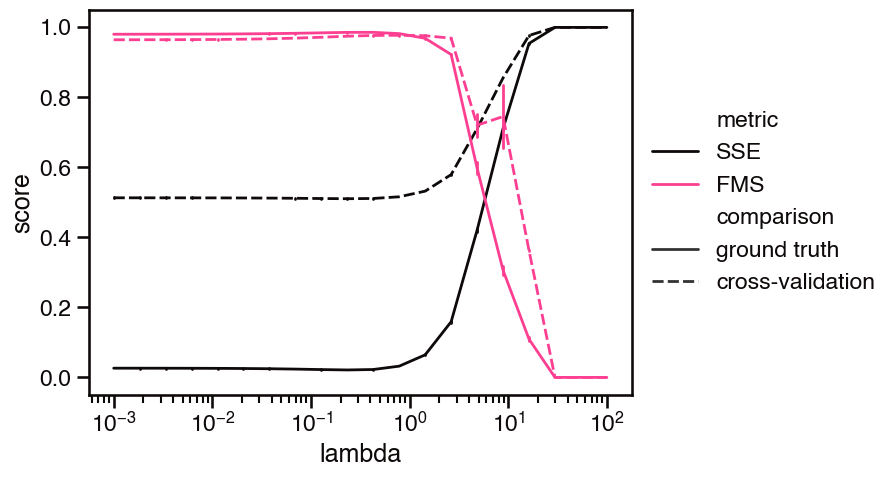

In [11]:
# plot reconstruction error and fms vs lambda

# select out plot data
plot_df = lambda_melt_df[lambda_melt_df['metric'].isin(['SSE', 'FMS'])]

# plot factor match score and sse
fig, axis = plt.subplots(figsize=(7, 5))
sns.lineplot(
    x='lambda', 
    y='score', 
    hue='metric', 
    style='comparison', 
    palette=sns.color_palette([accent_colors[i] for i in [4, 3]]), 
    errorbar='se', 
    err_style='bars',
    data=plot_df, 
    ax=axis, 
    legend=True
)
plt.legend(loc='center left', bbox_to_anchor=[1, 0.5])
plt.xscale('log')
plt.show()


# Figure 1c

Metrics comparing clusters to ground truth

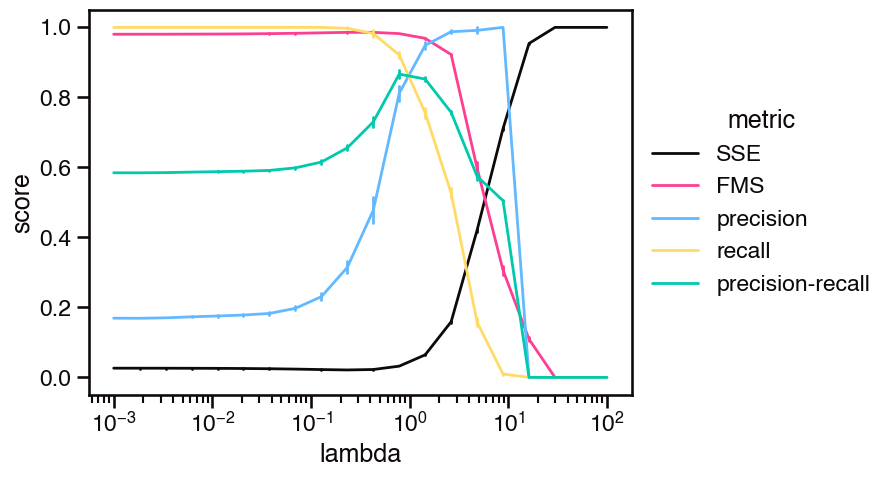

In [12]:
# select out plot data
plot_df = lambda_melt_df[lambda_melt_df['comparison'] == 'ground truth']

# plot factor match score and sse
fig, axis = plt.subplots(figsize=(7, 5))
sns.lineplot(
    x='lambda', 
    y='score', 
    hue='metric', 
    palette=sns.color_palette([accent_colors[i] for i in [4, 3, 7, 6, 2]]), 
    errorbar='se', 
    err_style='bars',
    data=plot_df, 
    ax=axis, 
    legend=True
)
plt.legend(title='metric', loc='center left', bbox_to_anchor=[1, 0.5])
plt.xscale('log')
plt.show()


# Figure 1d

Heatmap of optimal model components compared to ground truth

0.8302667578190268


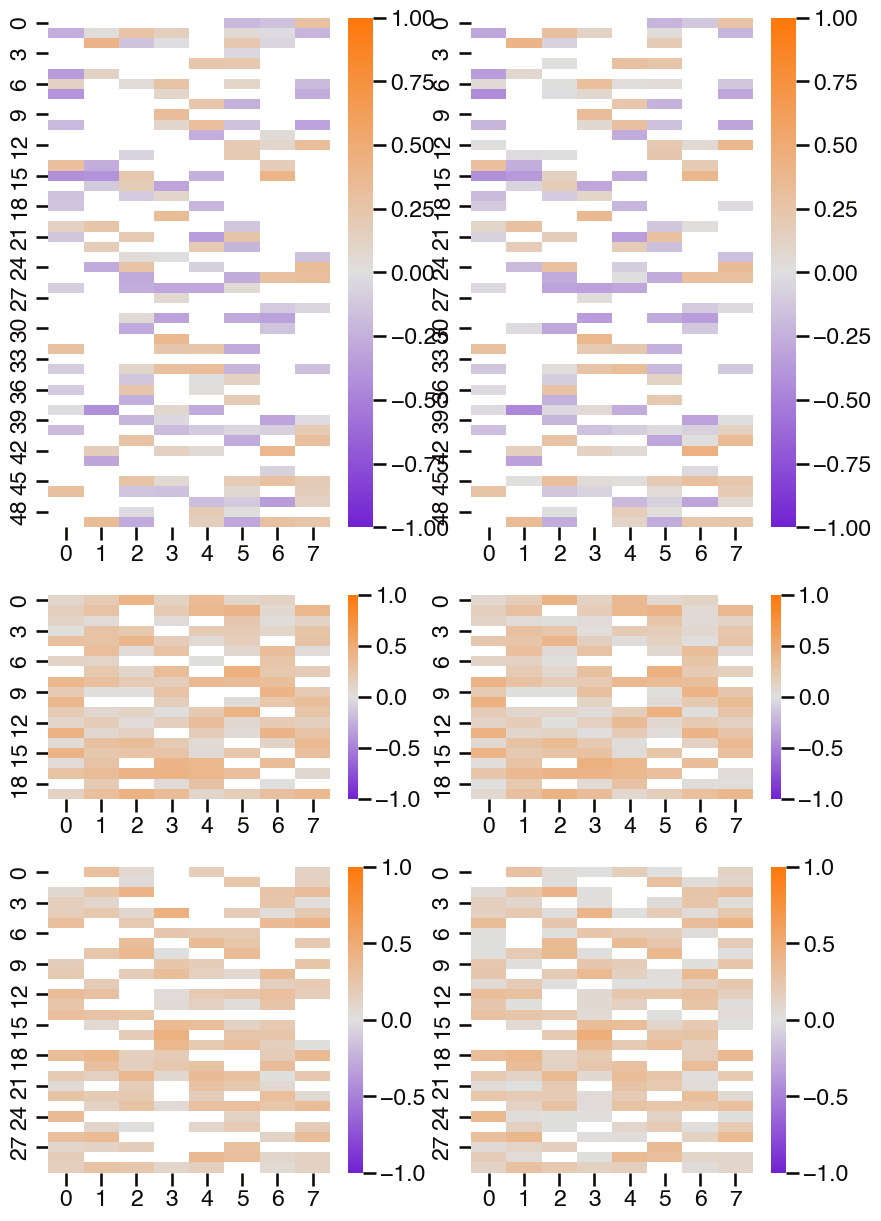

In [13]:
# decompose with optimal hyperparameters

model_params = {
    'rank': 8,
    'lambdas': [1.0, 0.0, 0.0], 
    'nonneg_modes': [1, 2],
    'tol': 1e-6, 
    'n_iter_max': 1000, 
    'n_initializations': 5
}
noise_level = 1.0

# run decomposition
cp = SparseCP(**model_params, random_state=rns).fit_transform(
    sim_tensor.to_tensor(noise_level=noise_level, sparse_noise=True, random_state=rns), threads=1, verbose=0
)

# calculate fms and get optimal permutation
fms, perm = factor_match_score(sim_tensor, cp, return_permutation=True)
best_cp = tlviz.factor_tools.permute_cp_tensor(cp, perm)
print(fms)

# plot factor heatmaps
heatmap_params = {'vmin':-1, 'vmax':1, 'cmap':div_cmap, 'center':0}
fig, ax = plot_factors_heatmap(
    tl.cp_normalize(best_cp).factors, 
    reference_factors=tl.cp_normalize(sim_tensor).factors, 
    mask_thold=[0, 0], 
    ratios=True, 
    heatmap_kwargs=heatmap_params)


# Full Figure 1

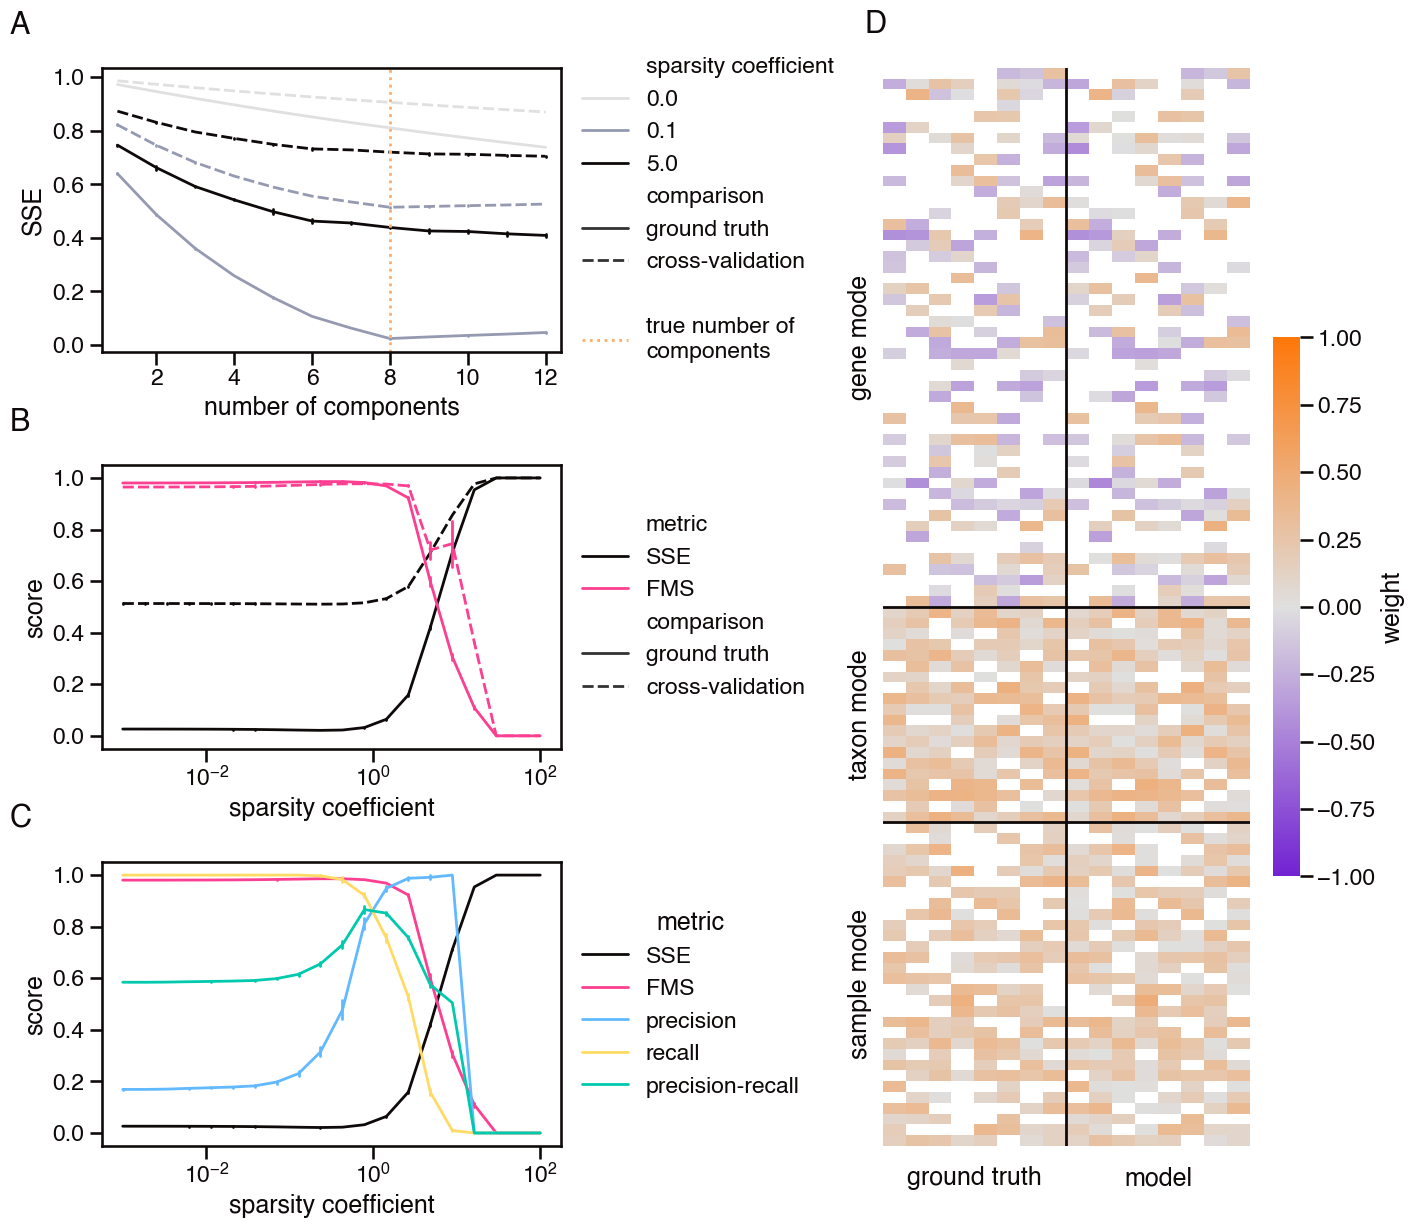

In [16]:
# make composite figure

fig = plt.figure(figsize=(16, 14))
grid = plt.GridSpec(3, 2, wspace=.7, hspace=.4)
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}


# plot panel a
ax_a = plt.subplot(grid[0,0])
ax_a.annotate('A', xy=(-0.2, 1.15), **annot_kwgs)
# get data together
rank_df['sparsity coefficient'] = ['{}'.format(l) for l in rank_df['lambda']]
# make figure
sns.lineplot(
    x='rank', 
    y='SSE', 
    hue='sparsity coefficient', 
    palette=sns.color_palette([grays[i] for i in [6, 3, 0]]), 
    style='comparison', 
    errorbar='se', 
    err_style='bars',
    data=rank_df, 
    ax=ax_a
)
ax_a.axvline(x=8, ymin=0, ymax=1, color='white', linestyle='dotted', label=' ')    # hack for blank space in legend
ax_a.axvline(x=8, ymin=0, ymax=1, color=accent_colors[1], linestyle='dotted', label='true number of\ncomponents')
ax_a.set(xlim=(0.6, 12.4), xlabel='number of components')
ax_a.legend(loc='center left', bbox_to_anchor=[1, 0.5]);


# plot panel b
ax_b = plt.subplot(grid[1,0])
ax_b.annotate('B', xy=(-0.2, 1.15), **annot_kwgs)
# select out plot data
plot_df = lambda_melt_df[lambda_melt_df['metric'].isin(['SSE', 'FMS'])]
# plot factor match score and sse
sns.lineplot(
    x='lambda', 
    y='score', 
    hue='metric', 
    style='comparison', 
    palette=sns.color_palette([accent_colors[i] for i in [4, 3]]), 
    errorbar='se', 
    err_style='bars',
    data=plot_df, 
    ax=ax_b, 
)
ax_b.set(xscale='log', xlabel='sparsity coefficient', ylabel='score')
ax_b.legend(loc='center left', bbox_to_anchor=[1, 0.5])


# plot panel c
ax_c = plt.subplot(grid[2,0])
ax_c.annotate('C', xy=(-0.2, 1.15), **annot_kwgs)
# select out plot data
plot_df = lambda_melt_df[lambda_melt_df['comparison'] == 'ground truth']
# plot factor match score and sse
sns.lineplot(
    x='lambda', 
    y='score', 
    hue='metric', 
    palette=sns.color_palette([accent_colors[i] for i in [4, 3, 7, 6, 2]]), 
    errorbar='se', 
    err_style='bars',
    data=plot_df, 
    ax=ax_c, 
)
ax_c.set(xscale='log', xlabel='sparsity coefficient', ylabel='score')
ax_c.legend(title='metric', loc='center left', bbox_to_anchor=[1, 0.5])


# plot panel d
ax_d = plt.subplot(grid[0:3,1])
ax_d.annotate('D', xy=(-0.05, 1.04), **annot_kwgs)
# get data in shape
cp_factors = tl.cp_normalize(best_cp).factors
sim_factors = tl.cp_normalize(sim_tensor).factors
data = np.concatenate(
    [np.concatenate([sim_factors[0], sim_factors[1], sim_factors[2]]), 
    np.concatenate([cp_factors[0], cp_factors[1], cp_factors[2]])], 
    axis=1
)
# plot heatmap
sns.heatmap(
    data, 
    mask=(data == 0), 
    cbar_kws={'shrink': 0.5, 'label': 'weight'}, 
    **heatmap_params, 
    xticklabels=False,
    yticklabels=False,
    ax=ax_d, 
);
ax_d.axvline(8, color=line_color);
ax_d.axhline(50, color=line_color);
ax_d.axhline(70, color=line_color);
ax_d.text(4, 103, 'ground truth', horizontalalignment='center', verticalalignment='center');
ax_d.text(12, 103, 'model', horizontalalignment='center', verticalalignment='center');
ax_d.text(-1, 25, 'gene mode', horizontalalignment='center', verticalalignment='center', rotation=90);
ax_d.text(-1, 60, 'taxon mode', horizontalalignment='center', verticalalignment='center', rotation=90);
ax_d.text(-1, 85, 'sample mode', horizontalalignment='center', verticalalignment='center', rotation=90);

fig.savefig('simulation-example-panel.png', bbox_inches='tight')
